# 3 Pre-processing Work and Model

## 3.1 Table of Contents

<a id='Imports'></a>
## 3.2 Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima
import statsmodels.api as sm
import math
from math import sqrt

<a id="Load-Data"></a>
## 3.3 Load the Data

Our goal is to model solar power generation effectively. Therefore, we should consider filtering out nighttime data, specifically during hours when AC_POWER and irradiation is zero, to focus solely on the time periods when solar power generation is feasible.

In [2]:
# Load the filtered data from CSV file into a Pandas DataFrame named 'filter_df'
filtered_df = pd.read_csv('/Users/aysebusra/Desktop/Springboard/Capstone_3/filtered_data.csv')

<a id="Explore-the-Data"></a>
## 3.4 Explore the Data

In [3]:
# Display the dimensions of the filtered_df data
filtered_df.shape

(32022, 17)

The filtered data has 32,022 rows and 16 columns

In [4]:
# Display the first few rows of the filtered_df data
filtered_df.head()

,DATE_TIME,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,EFFICIENCY
0,2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.451752
1,2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.435018
2,2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.488947
3,2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.438112
4,2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.525945


The filtered data has the following columns:'DATE_TIME', 'INVERTER', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATE', 'TIME', 'DAY', 'MONTH', 'WEEK', 'HOURS','MINUTES' and 'EFFICIENCY.

In [5]:
# Get an overview of the structure and characteristics of the filtered_df data
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32022 entries, 0 to 32021
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            32022 non-null  object 
 1   INVERTER             32022 non-null  int64  
 2   DC_POWER             32022 non-null  float64
 3   AC_POWER             32022 non-null  float64
 4   DAILY_YIELD          32022 non-null  float64
 5   TOTAL_YIELD          32022 non-null  float64
 6   AMBIENT_TEMPERATURE  32022 non-null  float64
 7   MODULE_TEMPERATURE   32022 non-null  float64
 8   IRRADIATION          32022 non-null  float64
 9   DATE                 32022 non-null  object 
 10  TIME                 32022 non-null  object 
 11  DAY                  32022 non-null  int64  
 12  MONTH                32022 non-null  int64  
 13  WEEK                 32022 non-null  int64  
 14  HOURS                32022 non-null  int64  
 15  MINUTES              32022 non-null 

There are no missing values in the dataset. Most of the data are numeric except for the ' DATE_TIME', ' DATE' and 'TIME' columns. Converting the ' DATE_TIME' column to datetime format will enable us to perform time-based analysis.

In [6]:
# Check for duplicate rows in the filtered_df data
duplicates = filtered_df.duplicated().sum()
print(f"Number of duplicate rows in filtered data: {duplicates}")

Number of duplicate rows in filtered data: 0


<a id='Preprocessing'></a>
## 3.5 Preprocessing Data

<a id="Convert-Datetime"></a>
### 3.5.1 Convert 'DATE_TIME' Columns to Datetime Object

In [7]:
# Convert 'DATE_TIME' columns to Datetime in the filtered_df data
filtered_df['DATE_TIME'] = pd.to_datetime(filtered_df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Set DATE_TIME as index
filtered_df.set_index(['DATE_TIME'], inplace=True)
filtered_df.head()

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,EFFICIENCY
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.451752
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.435018
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.488947
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.438112
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.525945


<a id="Handling-Cyclical-Nature"></a>
### 3.5.2 Handling Cyclical Nature of Time Variables

Since both 'HOURS' and 'MINUTES' are cyclical,these features converted into sine and cosine components. This transformation helps the model to recognize the continuity at the end and start of each cycle.

In [8]:
# Transform the HOURS and MINUTES into cyclical features
filtered_df['hours_sin'] = np.sin(filtered_df['HOURS'] * (2. * np.pi / 24))
filtered_df['hours_cos'] = np.cos(filtered_df['HOURS'] * (2. * np.pi / 24))
filtered_df['minutes_sin'] = np.sin(filtered_df['MINUTES'] * (2. * np.pi / 60))
filtered_df['minutes_cos'] = np.cos(filtered_df['MINUTES'] * (2. * np.pi / 60))

<a id="Droping"></a>
### 3.5.3 Droping Redundant Columns

In [9]:
# Drop the 'DATE', 'TIME', 'HOURS', and 'MINUTES'column in the filtered_df data
filtered_df.drop(['DATE', 'TIME', 'HOURS', 'MINUTES'], axis=1, inplace=True)
filtered_df.head()

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,EFFICIENCY,hours_sin,hours_cos,minutes_sin,minutes_cos
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,15,5,20,96.451752,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,15,5,20,96.435018,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,15,5,20,96.488947,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,15,5,20,96.438112,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,15,5,20,96.525945,1.0,6.123234e-17,0.0,1.0


<a id="Duplicates"></a>
### 3.5.4 Check for Duplicate Timestamps

In [10]:
# Check for duplicate indices
filtered_df[filtered_df.index.duplicated(keep=False)] 

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,EFFICIENCY,hours_sin,hours_cos,minutes_sin,minutes_cos
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.077230,0.012962,15,5,20,96.451752,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.077230,0.012962,15,5,20,96.435018,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.077230,0.012962,15,5,20,96.488947,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.077230,0.012962,15,5,20,96.438112,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.077230,0.012962,15,5,20,96.525945,1.0,6.123234e-17,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 18:45:00,18,3.771429,3.635714,4156.857143,5.207579e+05,23.965923,23.283976,0.002635,17,6,25,96.401515,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2020-06-17 18:45:00,19,2.857143,2.757143,3930.714286,1.211314e+08,23.965923,23.283976,0.002635,17,6,25,96.500000,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2020-06-17 18:45:00,20,3.780000,3.633333,4321.800000,2.427691e+06,23.965923,23.283976,0.002635,17,6,25,96.119929,-1.0,-1.836970e-16,-1.0,-1.836970e-16


The duplicates in the dataset are likely due to simultaneous recordings from multiple inverters. Aggregating this data is beneficial, as it allows for a consistent analysis of inverter efficiency and helps identify overarching trends.

<a id="Aggregation"></a>
### 3.5.5 Aggregate the Data

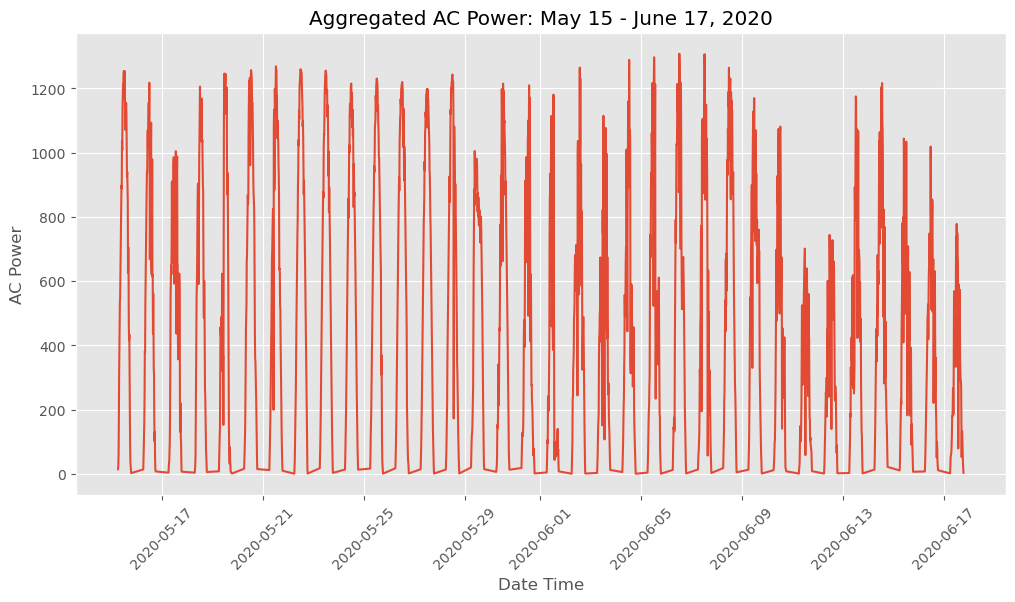

In [11]:
# Aggregate the data by taking the mean of all columns for each timestamp
aggregated_df = filtered_df.groupby('DATE_TIME').mean()

# Plot the Aggregated Target Variable
plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['AC_POWER'])
plt.title('Aggregated AC Power: May 15 - June 17, 2020')
plt.xlabel('Date Time')
plt.ylabel('AC Power')
plt.xticks(rotation=45)
plt.show()

<a id="Missing"></a>
### 3.5.6 Check for Missing Timestamps

In [12]:
# Resample the aggregated data to regular 15-minute intervals
resampled_df = aggregated_df.resample('15T').asfreq()

# Check for missing values after resampling
resampled_df.isnull().sum()

INVERTER               1499
DC_POWER               1499
AC_POWER               1499
DAILY_YIELD            1499
TOTAL_YIELD            1499
AMBIENT_TEMPERATURE    1499
MODULE_TEMPERATURE     1499
IRRADIATION            1499
DAY                    1499
MONTH                  1499
WEEK                   1499
EFFICIENCY             1499
hours_sin              1499
hours_cos              1499
minutes_sin            1499
minutes_cos            1499
dtype: int64

There are 1,499 missing values across all features after resampling, which suggests that no data was recorded during these 15-minute intervals.

<a id="HAndling-Missing-Values"></a>
#### 3.5.6.1 Handling Missing Values

In [13]:
# Interpolate missing timestamps
resampled_df.interpolate(method='linear', inplace=True)

In [14]:
# Check again for missing values
resampled_df.isnull().sum()

INVERTER               0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DAY                    0
MONTH                  0
WEEK                   0
EFFICIENCY             0
hours_sin              0
hours_cos              0
minutes_sin            0
minutes_cos            0
dtype: int64

Resampled dataframe has no missing values across all of its columns after the interpolation operation.

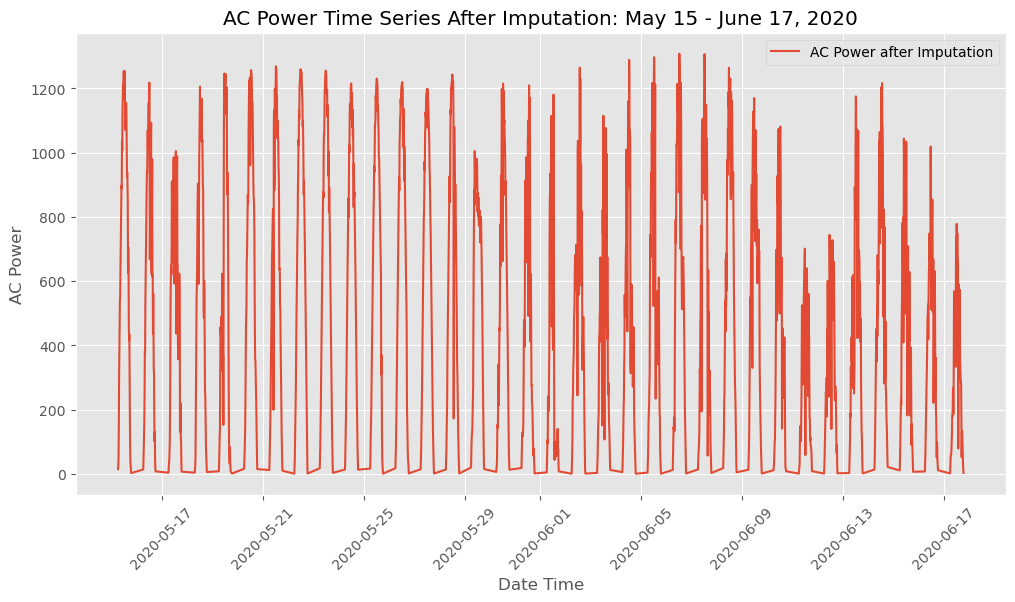

In [15]:
# Plot the Imputated Target Variable
plt.figure(figsize=(12, 6))
plt.plot(resampled_df['AC_POWER'], label='AC Power after Imputation')
plt.title('AC Power Time Series After Imputation: May 15 - June 17, 2020')
plt.xlabel('Date Time')
plt.ylabel('AC Power')
plt.legend()
plt.xticks(rotation=45)
plt.show()

<a id="Decomposition"></a>
## 3.6 Decomposition of Time Series

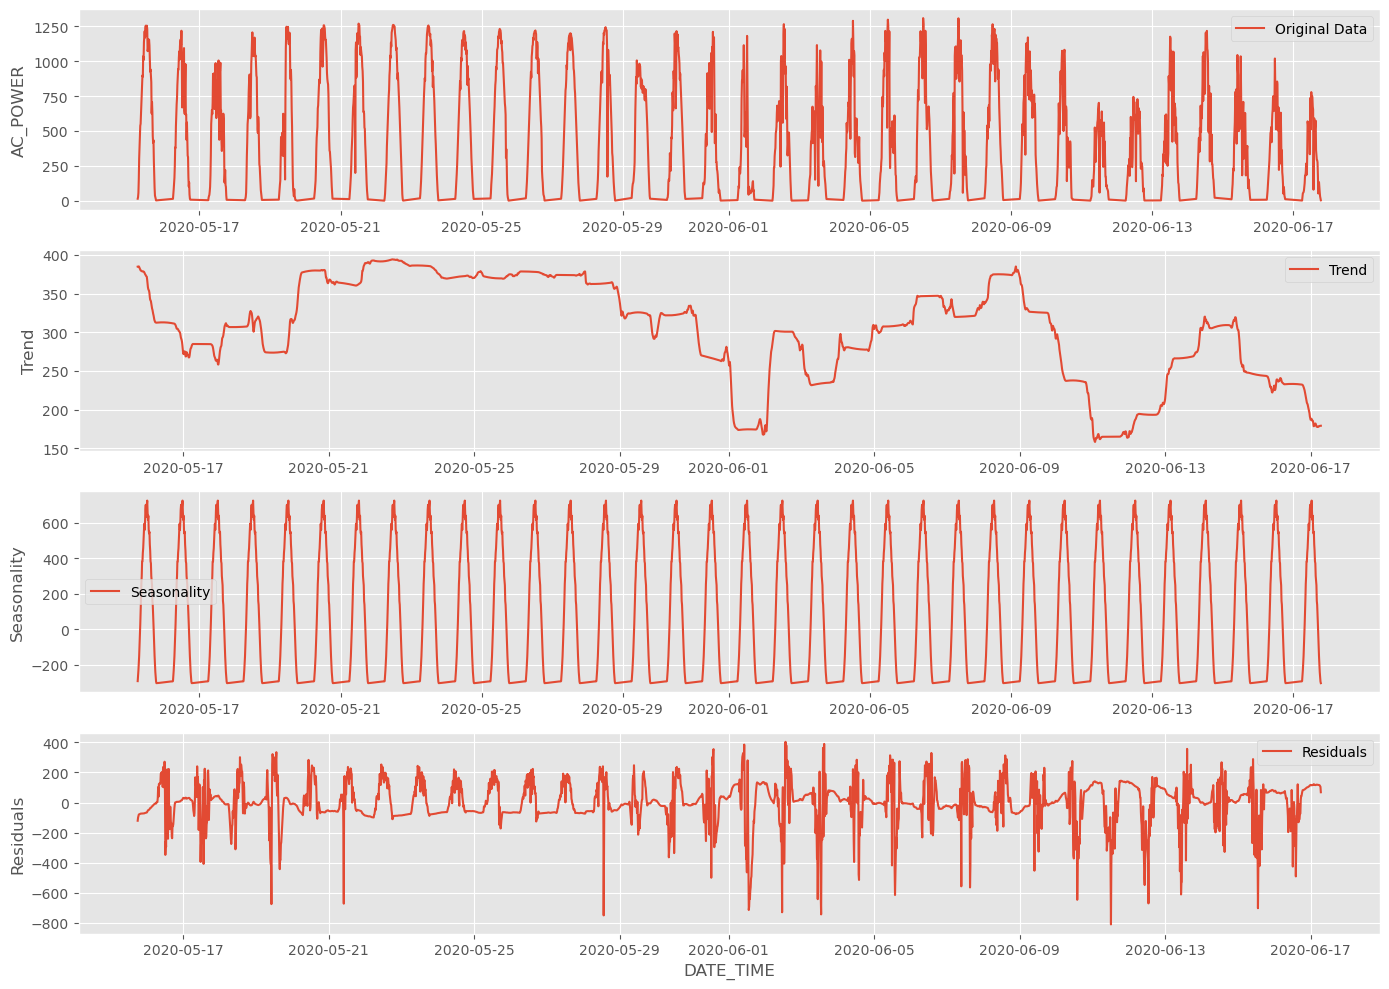

In [16]:
# Make a variable called decomposition, and assign it target variable and period passed to seasonal_decompose() 
decomposition = seasonal_decompose(resampled_df['AC_POWER'], period=96)

# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(14,10))
plt.subplot(4,1,1)
plt.plot(resampled_df['AC_POWER'], label='Original Data')
plt.ylabel('AC_POWER')
plt.legend(loc = 'best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.ylabel('Trend')
plt.legend(loc = 'best')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality')
plt.ylabel('Seasonality')
plt.legend(loc = 'best')

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc = 'best')
plt.ylabel('Residuals')
plt.xlabel('DATE_TIME')

plt.tight_layout()
plt.show()

* The original data shows fluctuations in AC_POWER generation, with clear peaks during daylight hours due to sunlight and drops to nearly zero at night.
* There is a noticeable decreasing trend in AC power output from May 15 to June 17, 2020, which may be attributed to seasonal changes or other external factors that impact efficiency.
* The seasonal plot displays a consistent pattern that matches the daily solar cycle, with peaks in midday solar generation and troughs at night when there is no solar activity.
* The residuals plot shows random fluctuations, suggesting that there are additional factors influencing power generation that are not captured by seasonal or trend components. These fluctuations could be due to weather conditions or operational issues.

<a id="Statistical-Test"></a>
## 3.7 Statistical Testing for Stationarity

<a id="ADF"></a>
#### 3.7.1 ADF Test

In [17]:
# Applying the Augmented Dickey-Fuller (ADF) test on the 'AC_POWER' data
adf_test = adfuller(resampled_df['AC_POWER'].dropna())

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -14.046848502474456
p-value: 3.2293424716514176e-26
Critical Values: {'1%': -3.4323926176073427, '5%': -2.8624425047982394, '10%': -2.567250423444633}


* The ADF statistic is much lower than the critical values at common significance levels (1%, 5%, and 10%). This suggests a strong rejection of the null hypothesis. 
* The p-value is extremely small, which strongly indicates that reject the null hypothesis.
* The test results indicates that the time series is stationary. This means it can be modeled as is, without needing further differencing to stabilize the mean.

<a id="KPSS"></a>
#### 3.7.2 KPSS Test

In [18]:
# Applying the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the 'AC_POWER' data
kpss_test = kpss(resampled_df['AC_POWER'].dropna())
print('KPSS Statistic:', kpss_test[0])
print('p-value:', kpss_test[1])
print('Critical Values:', kpss_test[3])

KPSS Statistic: 0.19517009520822529
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/nj/n6tphz5j5fv8t8plz420fkt00000gn/T/ipykernel_28264/88675219.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(resampled_df['AC_POWER'].dropna())


* The KPSS statistic is below the critical values, and the p-value is above 0.05, which suggests that we fail to reject the null hypothesis of stationarity.
* Both tests confirm that time series data is stationary, so there is no need for differencing to achieve stationarity. 

<a id="ACF-PACF"></a>
#### 3.7.4 Plot ACF and PACF

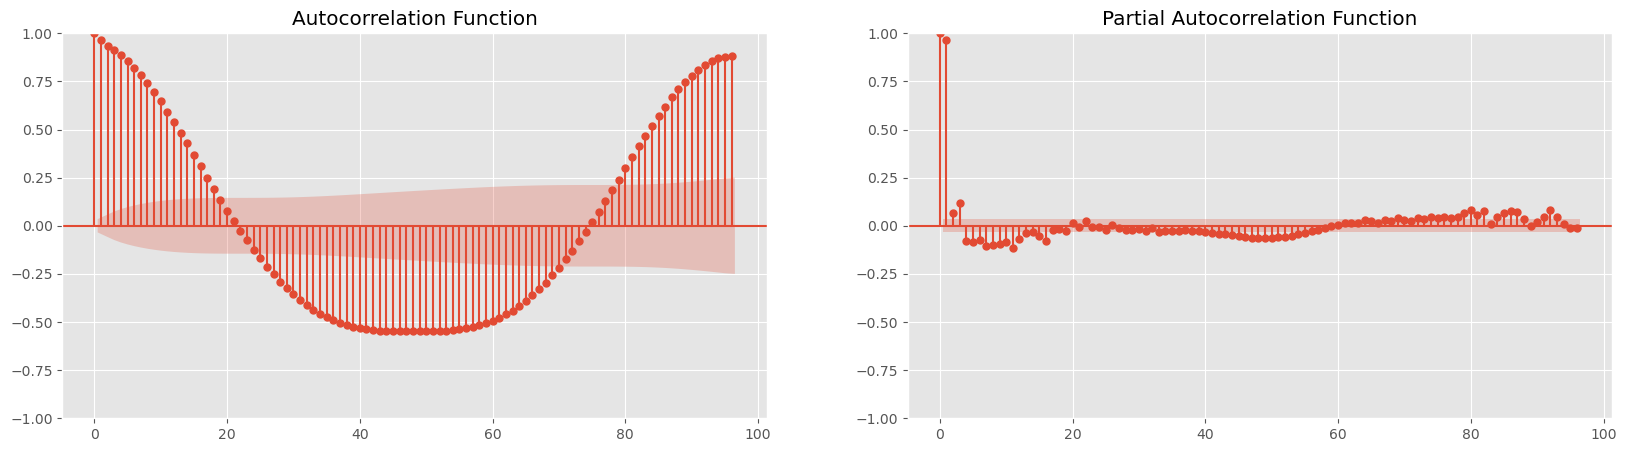

In [19]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot the Autocorrelation Function (ACF)
plot_acf(resampled_df['AC_POWER'], ax=ax1, lags=96, alpha=0.05)
ax1.set_title('Autocorrelation Function')

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(resampled_df['AC_POWER'], ax=ax2, lags=96, alpha=0.05)
ax2.set_title('Partial Autocorrelation Function')

plt.show()

* The ACF plot shows a wave-like pattern that gradually diminishes, suggesting seasonality in the data.
* The PACF plot has a significant spike at lag 1 and then quickly drops off, indicating a potential AR(1) component.
* Based on the plots:
    * AR (p): The significant spike at lag 1 in the PACF suggests an AR(1) component, so p=1.
    * Differencing (d): Since the series is already stationary, d=0.
    * MA (q): The ACF plot does not show a clear cutoff, suggesting q=0 or q=1.

<a id="Modeling"></a>
## 3.8 Modeling

<a id="SARIMA"></a>
### 3.8.1 SARIMA

Since the data has clear seasonal patterns, as indicated by decomposition and the periodic spikes in the ACF and PACF, it would be more efficient to start directly with SARIMA. 

In [20]:
# Split the data into training and testing sets based on the target variable
split = int(len(resampled_df) * 0.8)
train, test = resampled_df[:split], resampled_df[split:]

# Extract 'AC_POWER' for training and testing
train_ac_power = train['AC_POWER']
test_ac_power = test['AC_POWER']

In [21]:
# Define SARIMA model
sarima_model = SARIMAX(train_ac_power, order=(1, 0, 0), seasonal_order=(1, 1, 0, 96))
sarima_model_fit = sarima_model.fit()
sarima_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92288D+00    |proj g|=  6.57964D-02


 This problem is unconstrained.



At iterate    5    f=  5.91765D+00    |proj g|=  1.84775D-03

At iterate   10    f=  5.91247D+00    |proj g|=  2.74167D-02

At iterate   15    f=  5.90046D+00    |proj g|=  2.28239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   4.364D-06   5.900D+00
  F =   5.9004538036754539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           AC_POWER   No. Observations:                 2576
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 96)   Log Likelihood              -15199.569
Date:                            Mon, 01 Jul 2024   AIC                          30405.138
Time:                                    14:30:18   BIC                          30422.586
Sample:                                05-15-2020   HQIC                         30411.475
                                     - 06-11-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7149      0.007    102.359      0.000       0.701       0.729
ar.S.L96      -0.4977      0.008    -65.320      0.000      -0.513      -0.483
sigma2      1.221e+04    123.493     98.868      0.000     1.2e+04    1.25e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             22865.15
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.43   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Both AIC and BIC are relatively high.
* ar.L1: Autoregressive term of lag 1 is significant and positive (0.7149), suggesting a strong positive correlation with the previous value.
* ar.S.L96: Seasonal autoregressive term at lag 96 is significant and negative (-0.4977), indicating a negative correlation with the value 96 periods ago.
* sigma2: The variance of the model residuals is large, suggesting significant variability in model predictions.

In [22]:
# Forecast using SARIMA model
sarima_forecast = sarima_model_fit.forecast(steps=len(test_ac_power))
sarima_forecast = pd.Series(sarima_forecast, index=test_ac_power.index)

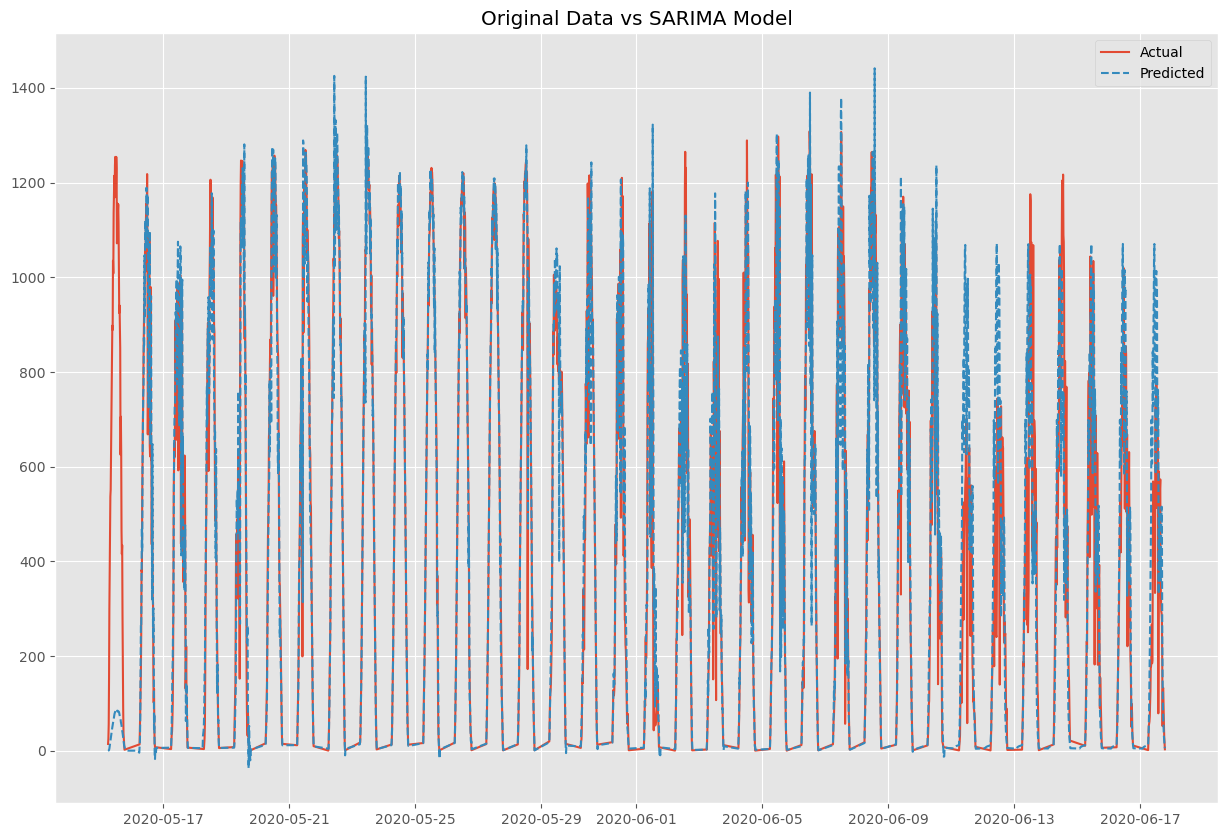

In [23]:
# Plot forecast against actual values
plt.figure(figsize=(15,10))
plt.plot(resampled_df['AC_POWER'], label='Actual')
plt.plot(sarima_model_fit.predict(start=0, end=len(resampled_df)-1), linestyle='dashed', label='Predicted')
plt.title('Original Data vs SARIMA Model')
plt.legend()
plt.show()

The plot compares the actual values against the SARIMA model's predicted values. The plot shows:
* The model captures the general trend and seasonality well.
* There is a close alignment between the actual and predicted values during many periods.
* Some deviations are noticeable, particularly during periods of rapid change.

In [24]:
# Calculate metrics for SARIMA
sarima_forecast = sarima_model_fit.forecast(steps=len(test))
sarima_r2 = r2_score(test['AC_POWER'], sarima_forecast)
sarima_mae = mean_absolute_error(test['AC_POWER'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test['AC_POWER'], sarima_forecast))
sarima_mape = np.mean(np.abs((test['AC_POWER'] - sarima_forecast) / test['AC_POWER'])) * 100

print(f"SARIMA R²: {sarima_r2}")
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"SARIMA MAPE: {sarima_mape}")

SARIMA R²: 0.6012771605298581
SARIMA MAE: 103.72826136854009
SARIMA RMSE: 187.43981769027738
SARIMA MAPE: 91.07737346631659


* The R² value of 0.6013 suggests the SARIMA model captures a significant portion of the variance but also indicates room for improvement.
* On average, the predictions of the SARIMA model are about 103.73 units away from the actual data points. 
* The average squared error of the predictions is 187.44. 
* On average, the model’s predictions are off by 91.08% from the actual values. This high percentage indicates that the model may not be capturing some aspects of the data well. 

<a id="Tune-SARIMA"></a>
### 3.8.2 Fine-Tuning a SARIMA Model

In [ ]:
# Use auto_arima to find the best parameters
sarima_model = auto_arima(
    train_ac_power,
    seasonal=True,
    m=96,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=0,
    start_P=0, max_P=3,
    start_Q=0, max_Q=3,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[96] intercept   : AIC=32555.842, Time=11.32 sec
 ARIMA(1,0,0)(1,1,0)[96] intercept   : AIC=inf, Time=381.62 sec


In [ ]:
# Forecast using the fine-tune model
sarima_forecast = sarima_model.predict(n_periods==len(test_ac_power))
sarima_forecast = pd.Series(sarima_forecast, index=test_ac_power.index)

In [ ]:
# Plot forecast against actual values
plt.figure(figsize=(15,10))
plt.plot(resampled_df['AC_POWER'], label='Actual')
plt.plot(sarima_model.predict_in_sample(), linestyle='dashed', label='Predicted')
plt.title('Original Data vs SARIMA Model')
plt.legend()
plt.show()

In [ ]:
# Calculate metrics
sarima_forecast = sarima_model_fit.forecast(steps=len(test))
sarima_r2 = r2_score(test['AC_POWER'], sarima_forecast)
sarima_mae = mean_absolute_error(test['AC_POWER'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test['AC_POWER'], sarima_forecast))
sarima_mape = np.mean(np.abs((test['AC_POWER'] - sarima_forecast) / test['AC_POWER'])) * 100

print(f"SARIMA R²: {sarima_r2}")
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"SARIMA MAPE: {sarima_mape}")